In [65]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_columns = None

In [3]:
df = pd.read_csv('../materials/processed_df.csv')
df.head()

,ID,wiek,PSA,PSAdensity,MRI vol,MRI Pirads,MRI EPE (naciek poza torebke),MRI EPE L,MRI EPE P,MRI SVI (pecherzyki),MRI SVI L,MRI SVI P,MRI SIZE,Bx ISUP Grade P,Bx ISUP Grade L,ISUP RP,ISUP RP P,ISUP RP L,SM +,N +,EPE RP,EPE L RP,EPE P RP,SVI RP,SVI RP L,SVI RP P,TNM,EPE micro,EPE macro,EPE false_positive,Bx ISUP Grade
0,ID00000,63.0,5.11,0.146000,35.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,10.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t2,0.0,0.0,1.0,1.0
1,ID00008,64.0,5.39,0.179667,30.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,3.0,3.0,3.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,t3a,1.0,0.0,0.0,3.0
2,ID00049,64.0,8.30,0.207500,40.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t2c,0.0,0.0,0.0,1.0
3,ID00001,56.0,6.80,0.200000,34.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,2.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pt2c,0.0,0.0,0.0,2.0
4,ID00002,59.0,40.00,2.222222,18.0,5.0,1.0,1.0,0.0,1.0,1.0,0.0,18.0,1.0,2.0,5.0,4.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,t3a,0.0,1.0,0.0,2.0


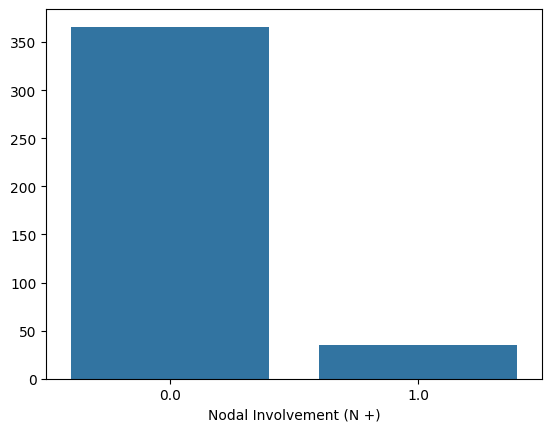

In [9]:
sns.barplot(x=df['N +'].value_counts().index, y=df['N +'].value_counts().values)
plt.xlabel('Nodal Involvement (N +)')
plt.show()

In [10]:
df.columns

Index(['ID', 'wiek', 'PSA', 'PSAdensity', 'MRI vol', 'MRI Pirads',
       'MRI EPE (naciek poza torebke)', 'MRI EPE L', 'MRI EPE P',
       'MRI SVI (pecherzyki)', 'MRI SVI L', 'MRI SVI P', 'MRI SIZE',
       'Bx ISUP Grade P', 'Bx ISUP Grade L', 'ISUP RP', 'ISUP RP P',
       'ISUP RP L', 'SM +', 'N +', 'EPE RP', 'EPE L RP', 'EPE P RP', 'SVI RP',
       'SVI RP L', 'SVI RP P', 'TNM', 'EPE micro', 'EPE macro',
       'EPE false_positive', 'Bx ISUP Grade'],
      dtype='object')

In [11]:
unused_columns = ['ID',
                  'ISUP RP', 'ISUP RP P', 'ISUP RP L',
                  'SM +', 'N +',
                  'EPE RP', 'EPE L RP', 'EPE P RP',
                  'SVI RP', 'SVI RP L', 'SVI RP P',
                  'TNM',
                  'EPE micro', 'EPE macro', 'EPE false_positive']
X = df.drop(columns=unused_columns)
y = df['N +']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
numerical_cols = ['wiek', 'PSA', 'PSAdensity', 'MRI vol', 'MRI Pirads', 'MRI SIZE']
categorical_cols = ['MRI EPE (naciek poza torebke)', 'MRI EPE L', 'MRI EPE P', 'MRI SVI (pecherzyki)', 'MRI SVI L', 'MRI SVI P', 'Bx ISUP Grade P', 'Bx ISUP Grade L', 'Bx ISUP Grade']

In [ ]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('normalization', MinMaxScaler())
])
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

In [34]:
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)

In [38]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_expanded, y_train_expaneded = smote.fit_resample(X_train_processed, y_train)
y_train_expaneded.value_counts()

N +
0.0    292
1.0    292
Name: count, dtype: int64

In [41]:
model = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
scores = cross_val_score(model, X_train_expanded, y_train_expaneded, cv=cv, scoring='accuracy')
print(scores)
print(f"Mean: {scores.mean()}+-{scores.std()}")

[0.94017094 0.95726496 0.94871795 0.97435897 0.95689655]
Mean: 0.9554818744473916+-0.011328733352804743


In [44]:
model.fit(X_train_expanded, y_train_expaneded)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [42]:
X_test_processed = preprocessor.transform(X_test)

In [61]:
y = model.predict(X_test_processed)

In [62]:
fpr, tpr, thresholds = roc_curve(y_test, y)

In [63]:
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

AUC: 0.6293436293436293


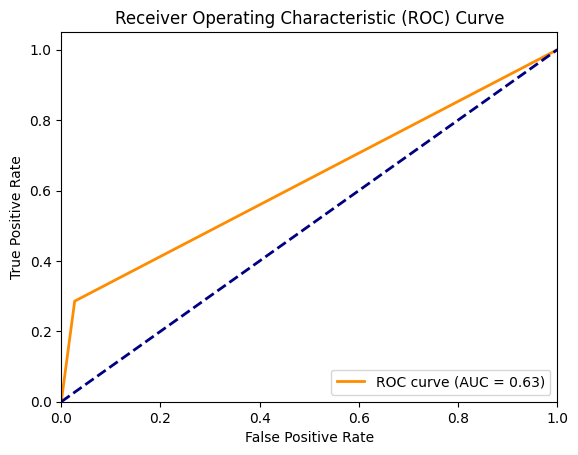

In [57]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [66]:
cm = confusion_matrix(y_test, y)

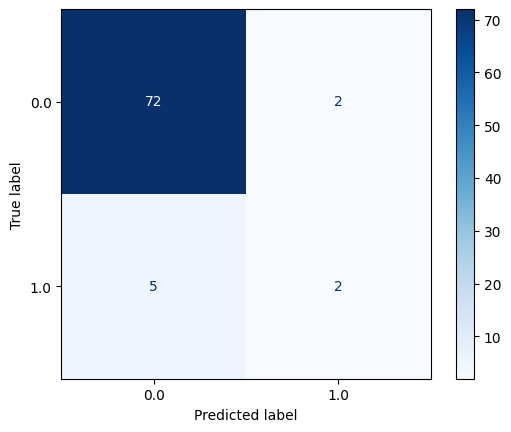

In [67]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.show()